## 8.1 序列模型

### 8.1.1 统计工具

在进行预测的时候，需要借用前面的离散数据预测后一个时间的数据，这时候就需要通过如下途径进行预测。

$$
x_t\sim P(x_t|x_{t-1},\dots,x_1)
$$

#### 8.1.1.1 自回归模型

如何有效估计$P(x_t|x_{t-1},\dots,x_1)$，可以有以下的两种策略：

第一种是我们无需去观察相当长的序列，而是只观察序列$x_{t-1},\dots,x_{t-\tau}$，这样的好处是参数的数量总是不变的。这样的模型被称为自回归模型，因为其对自己执行回归。

第二种是保留一些对过去观测的总结$h_t$，同时更新预测$\hat{x_t}$和总结$h_t$，这产生了基于$\hat{x_t}=P(x_t|h_t)$估计$x_t$，以及公式$h_t=g(h_{t-1},x_{t-1})$更新的模型。这样的模型被称为隐变量自回归模型。

![](../images/8-1-2.svg)

整个序列的估计值都将通过以下的方式获得

$$
P(x_1,\dots,x_T)=\prod_{t=1}^TP(x_t|x_{t-1},\dots,x_1)
$$

#### 8.1.1.2 马尔可夫模型

如果我们使用$x_{t-1},\dots,x_{t-\tau}$而不是$x_{t-1},\dots,x_1$来估计$x_t$，则该序列满足**马尔可夫模型**。特别的，如果$\tau=1$，则得到一个**一阶马尔可夫模型**，有

$$
P(x_1,\dots,x_T)=\prod_{t=1}^TP(x_t|x_{t-1})当P(x_1|x_0)=P(x_1)
$$

#### 8.1.1.3 因果关系

也就是对于马尔可夫模型而言，我们还可以得到一个反向的概率分布。

### 8.1.2 训练

先使用正弦函数和噪声生成序列数据

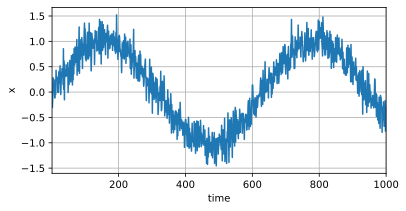

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接着将这个数据转化为特征-标签(freture-label)对，在这里仅使用前600个“特征-标签”进行训练。

其中特征是$\bm{x}_t=[x_{t-\tau}\dots,x_{t-1}]$。

其中标签是$y_t=x_t$

In [3]:
tau = 4
# 前tau步由于数据不足无法作为数据，故不作为特征
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # features的一行代表一个特征向量
    # 一列代表特征向量中的第几个特征
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里使用一个简单的架构搭建模型

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

下面开始训练，训练方法差不多

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.083271
epoch 2, loss: 0.064288
epoch 3, loss: 0.061210
epoch 4, loss: 0.058904
epoch 5, loss: 0.058534


### 8.1.3 预测

下面的预测是检查预测下一个时间步的能力，也就是紫色的每一个数据都是在知道前面4个数据后进行预测的，也就是**单步预测**。

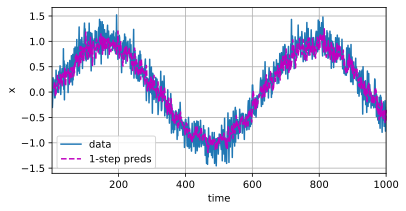

In [6]:
onestep_preds = net(features)
d2l.plot(
    # 在这里time[tau:]表示前面的tau步由于数据不足无法预测
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
    'x', legend=['data', '1-step preds'], xlim=[1, 1000],
    figsize=(6, 3)
)

但是上述的单步预测实际上还是**利用了原始数据集**，下面使用自己的预测作为数据集进行预测。

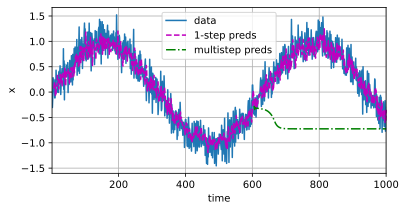

In [7]:
multistep_preds = torch.zeros(T)
# 前面的n_train+tau步使用原始数据
multistep_preds[: n_train + tau] = x[: n_train + tau]
# 后面的T-n_train-tau步使用自己预测出来的数据
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

很明显，这个效果很差，主要是由于累计了错误导致的。

基于$k=1,4,16,64$，通过对整个预测序列的计算，可以看一下$k$步预测的困难。

下面的feature构建了一个表，每一行代表一个$x_t$所对应的特征，其中前面$\tau$列是来自$x$的真实数据，而后面从$\tau$到$\tau+\rm{max\_step}$的列都是预测而来的数据。

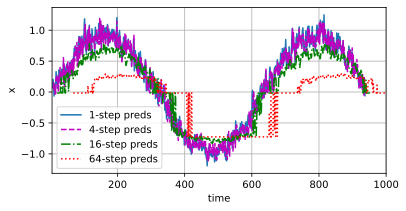

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

直接说明多步预测不行

### 8.1.4 小结

- 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。

- 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。

- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。

- 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。